In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from opencc import OpenCC
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from keras.layers.normalization import layer_normalization
from keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, BertConfig, BertModel

%config InlineBackend.figure_format = "retina"

In [2]:
bert_path = './chinese_roberta_wwm_ext_pytorch'
tokenizer = BertTokenizer(f'{bert_path}/vocab.txt')
config = BertConfig.from_pretrained(f'{bert_path}/bert_config.json')
embedding = BertModel.from_pretrained(f'{bert_path}/pytorch_model.bin', config=config)

Some weights of the model checkpoint at ./chinese_roberta_wwm_ext_pytorch/pytorch_model.bin were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
total_count, X, Y = 317305, list(), list()

cc = OpenCC('s2t')
data_path = './comment_data_v2'
type_names = ['attraction', 'bookstore', 'medical', 'restaurant', 'shopping']
progress = tqdm(total = total_count)

for type_label, type_name in enumerate(type_names):
    df = pd.read_excel(f'{data_path}/{type_name}.xlsx')
    for data in df.iloc:
        semantic_label = int(data['Star'] > 3)
        text = cc.convert(data['Comment'])
        X.append(tokenizer.encode(text))
        Y.append([semantic_label, type_label])
        progress.update(1)
    
X = pad_sequences(X, maxlen = 100, padding = 'post', dtype = 'int')
X, Y = torch.tensor(X), torch.tensor(Y)

torch.manual_seed(2)
shuffle_order = torch.randperm(X.shape[0])
X, Y = X[shuffle_order], Y[shuffle_order]

  0%|          | 0/317305 [00:00<?, ?it/s]

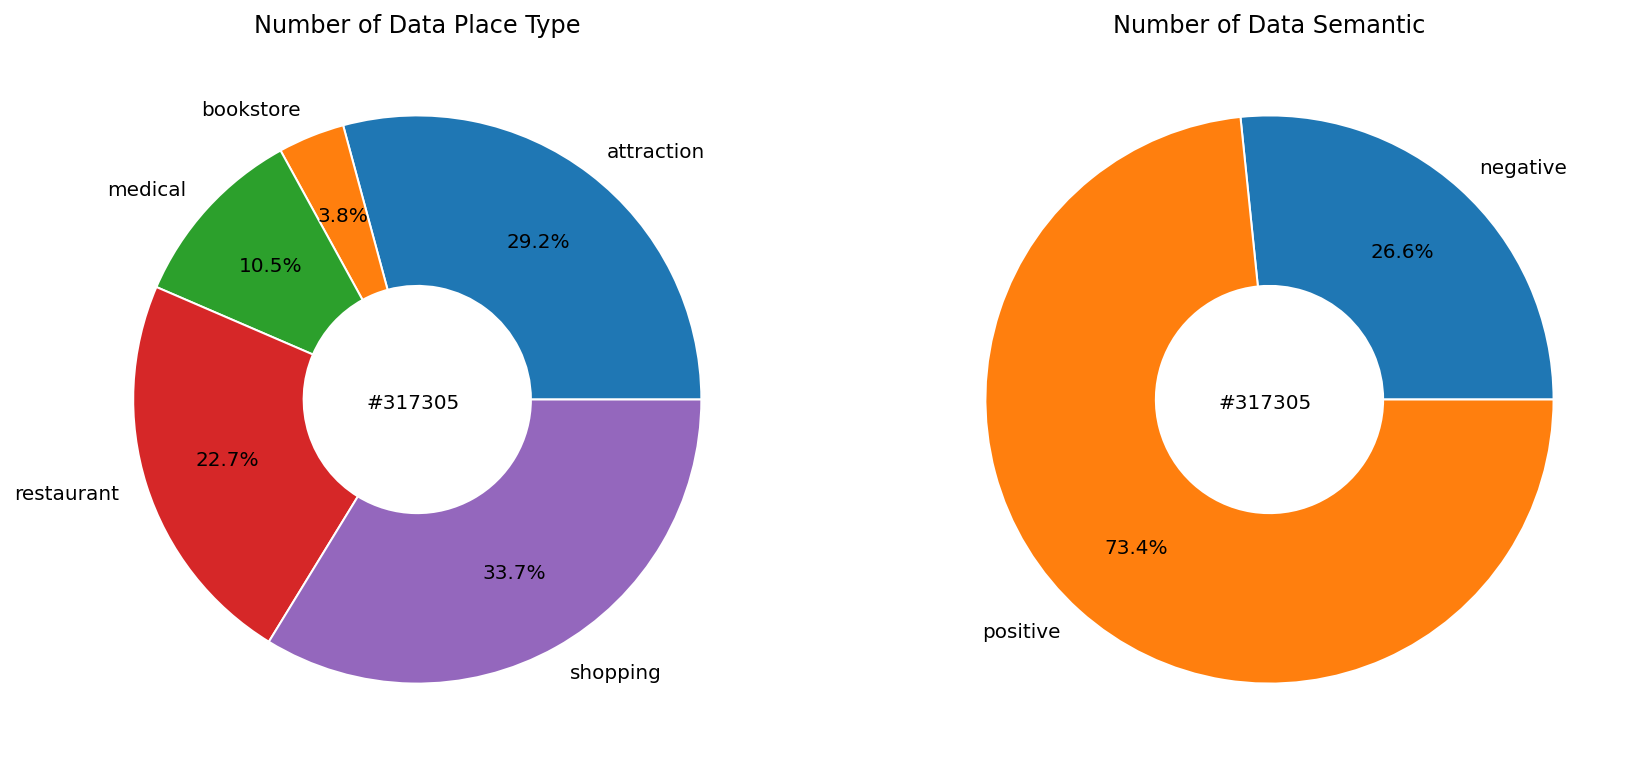

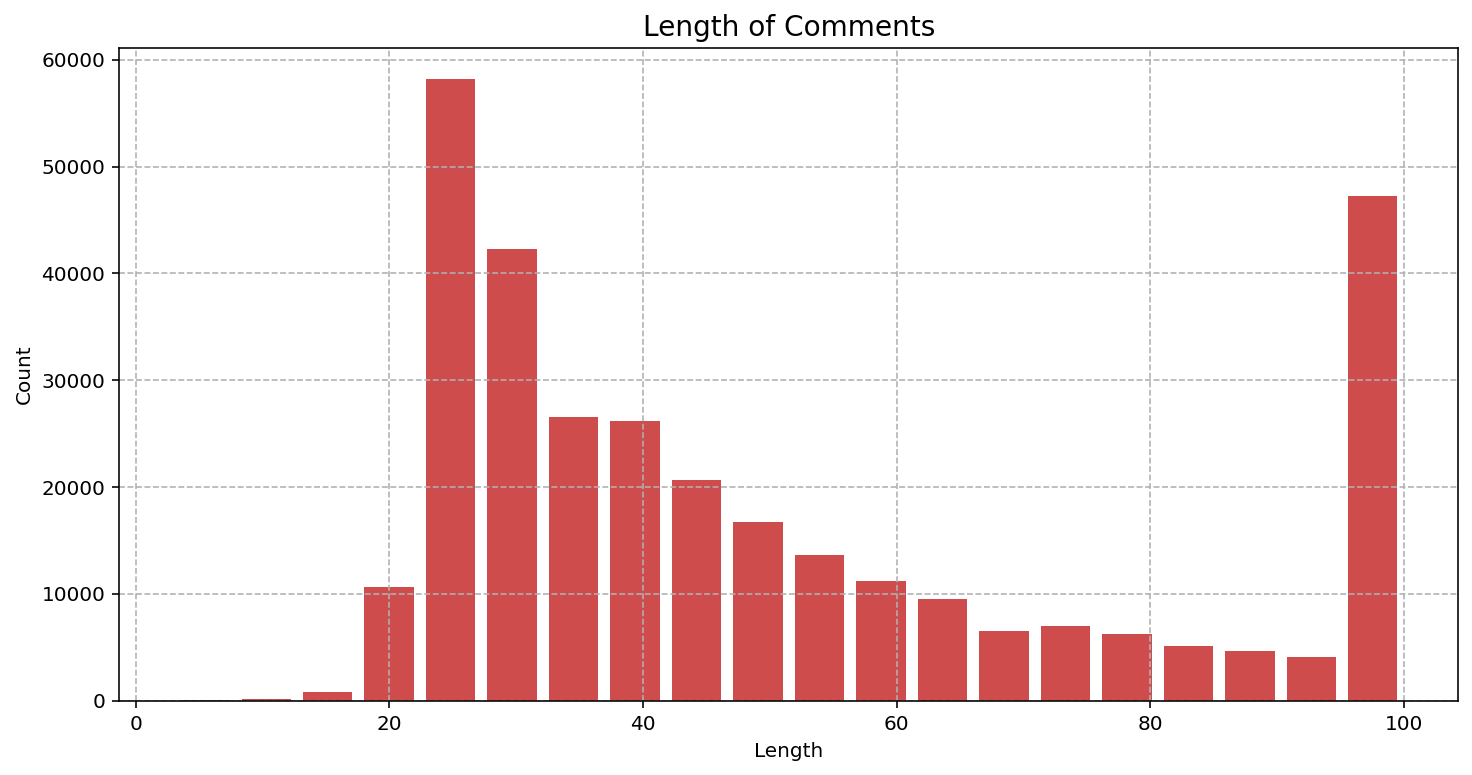

In [4]:
if Y.shape[1] == 2: Y = Y.transpose(1, 0)

size = [len(np.where(Y[1] == i)[0]) for i in range(5)]

fig, axes = plt.subplots(1, 2, figsize = (14, 14))

axs = axes[0]
axs.pie(size, labels = type_names, autopct = "%1.1f%%", pctdistance = 0.7, wedgeprops = dict(width = 0.6, edgecolor = 'w'))
axs.text(-0.18, -0.03, f'#{total_count}')
axs.set_title("Number of Data Place Type", fontsize = 12) 

negative_count = len(np.where(Y[0] == 0)[0])
positive_count = len(np.where(Y[0] == 1)[0])

axs = axes[1]
axs.pie([negative_count, positive_count], labels = ['negative', 'positive'], autopct = "%1.1f%%", pctdistance = 0.7, wedgeprops = dict(width = 0.6, edgecolor = 'w'))
axs.text(-0.18, -0.03, f'#{total_count}')
axs.set_title("Number of Data Semantic", fontsize = 12) 

length = [len(np.nonzero(x)) for x in X]

plt.figure(figsize = (12, 6))
plt.grid(ls = '--')
plt.hist(length, bins = 20, alpha = 0.7, color = '#BB0000', rwidth = 0.8)
plt.title("Length of Comments", fontsize = 14)
plt.xlabel('Length')
plt.ylabel('Count')

plt.show()

In [5]:
if Y.shape[0] == 2: Y = Y.transpose(1, 0)
    
train_X, val_X = X[:int(X.shape[0] * 0.8)], X[int(X.shape[0] * 0.8):]
train_Y, val_Y = Y[:int(Y.shape[0] * 0.8)], Y[int(Y.shape[0] * 0.8):]

batch_size = 64
train_dataset, val_dataset = TensorDataset(train_X, train_Y), TensorDataset(val_X, val_Y)
train_loader, val_loader = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 4), DataLoader(val_dataset, batch_size, shuffle = False, num_workers = 4)

In [6]:
class bert_model(nn.Module):
    def __init__(self, embedding):
        super(bert_model, self).__init__()
        self.embedding = embedding
        self.fc1 = nn.Linear(768, 2)
        self.fc2 = nn.Linear(768, 5)
    def forward(self, x):
        embedded = self.embedding(x)['pooler_output']
        out1 = self.fc1(embedded)
        out2 = self.fc2(embedded)
        return out1, out2

In [7]:
def get_log_string(epoch, num_epoch, epoch_start_time, val_acc1, val_acc2, val_count):
    log_string = '[{:02d}/{:02d}] {:2.2f} sec, Val Acc1: {:3.2f}% Acc2: {:3.2f}%' \
                .format(epoch + 1, num_epoch, time.time() - epoch_start_time, \
                val_acc1 / val_count * 100, val_acc2 / val_count * 100)
    return log_string

In [8]:
model = bert_model(embedding).cuda()
model.load_state_dict(torch.load(f'{bert_path}/best_model1.pth'))

num_epoch = 1
progress = tqdm(total = len(val_loader), colour = 'orange', bar_format = '{desc}{percentage:3.0f}%|{bar}|{n}/{total}[{rate_fmt}{postfix}]')

for epoch in range(num_epoch):
    epoch_start_time, semantic_p = time.time(), list()
    val_acc1, val_acc2, val_count = 0.0, 0.0, 1e-3
        
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            pred1, pred2 = model(data[0].cuda())
            
            val_acc1 += np.sum(np.argmax(pred1.cpu().data.numpy(), axis = 1) == data[1][:, 0].numpy())
            val_acc2 += np.sum(np.argmax(pred2.cpu().data.numpy(), axis = 1) == data[1][:, 1].numpy())
            val_count += batch_size
            
            semantic_p.append(np.argmax(pred1.cpu().data.numpy(), axis = 1))
            
            progress.set_description(get_log_string(epoch, num_epoch, epoch_start_time, val_acc1, val_acc2, val_count))
            progress.update(1)

  0%|          |0/992[?it/s]

In [9]:
model = bert_model(embedding).cuda()
model.load_state_dict(torch.load(f'{bert_path}/best_model2.pth'))

num_epoch = 1
progress = tqdm(total = len(val_loader), colour = 'orange', bar_format = '{desc}{percentage:3.0f}%|{bar}|{n}/{total}[{rate_fmt}{postfix}]')

for epoch in range(num_epoch):
    epoch_start_time, place_p = time.time(), list()
    val_acc1, val_acc2, val_count = 0.0, 0.0, 1e-3
        
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            pred1, pred2 = model(data[0].cuda())
            
            val_acc1 += np.sum(np.argmax(pred1.cpu().data.numpy(), axis = 1) == data[1][:, 0].numpy())
            val_acc2 += np.sum(np.argmax(pred2.cpu().data.numpy(), axis = 1) == data[1][:, 1].numpy())
            val_count += batch_size
            
            place_p.append(np.argmax(pred2.cpu().data.numpy(), axis = 1))
            
            progress.set_description(get_log_string(epoch, num_epoch, epoch_start_time, val_acc1, val_acc2, val_count))
            progress.update(1)

  0%|          |0/992[?it/s]

In [10]:
semantic_predicted, semantic_answer = list(), [value[0] for value in list(val_Y.cpu().numpy())]
for predict in semantic_p: semantic_predicted.extend(p for p in predict)

place_predicted, place_answer = list(), [value[1] for value in list(val_Y.cpu().numpy())]
for predict in place_p: place_predicted.extend(p for p in predict)

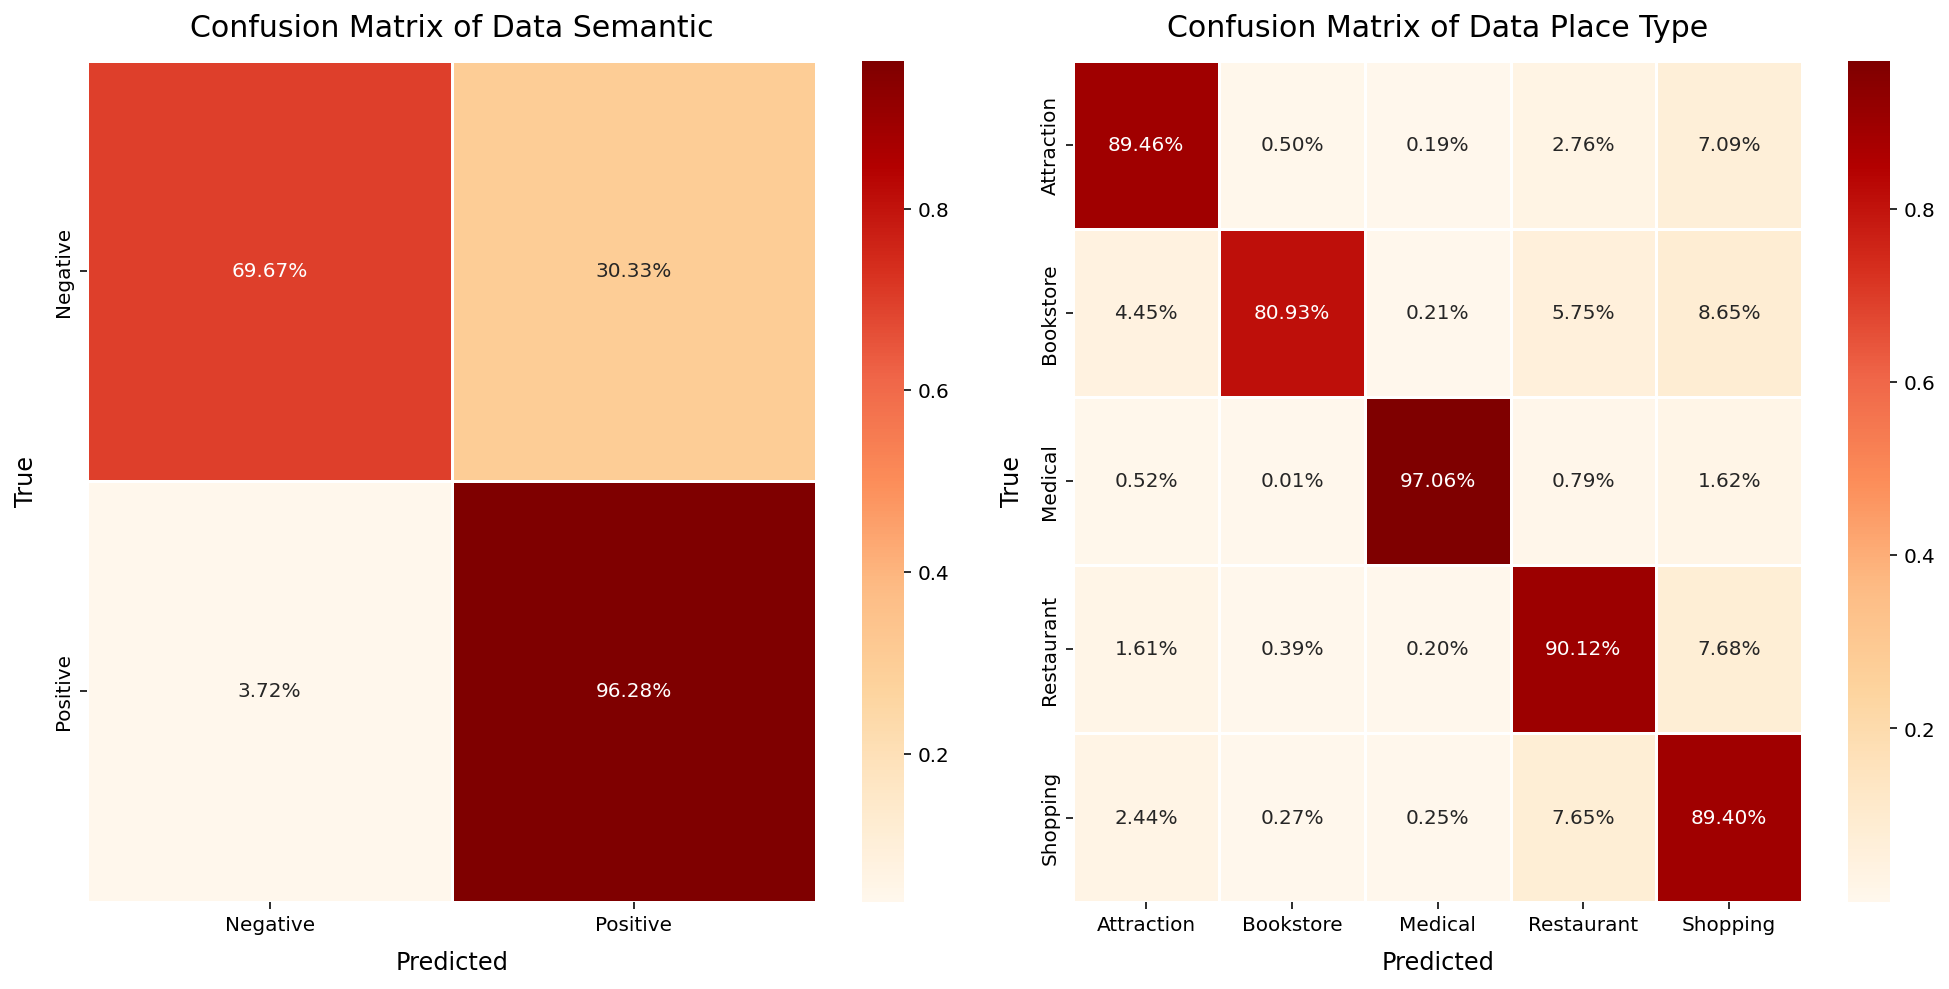

In [11]:
semantic_matrix = confusion_matrix(semantic_answer, semantic_predicted)
semantic_matrix = semantic_matrix.astype('float') / semantic_matrix.sum(axis = 1)[:, np.newaxis]

place_matrix = confusion_matrix(place_answer, place_predicted)
place_matrix = place_matrix.astype('float') / place_matrix.sum(axis = 1)[:, np.newaxis]

semantic_labels = ["Negative", "Positive"]
place_labels = ['Attraction', 'Bookstore', 'Medical', 'Restaurant', 'Shopping']

plt.figure(figsize = (14, 7))

plt.subplot(121)
sns.heatmap(semantic_matrix, annot = True, cmap = 'OrRd', linewidths = 1.5, fmt = '.2%', xticklabels = semantic_labels, yticklabels = semantic_labels)
plt.title("Confusion Matrix of Data Semantic", fontsize = 15, pad = 12)
plt.xlabel("Predicted", fontsize = 12, labelpad = 8)
plt.ylabel("True", fontsize = 12, labelpad = 8)

plt.subplot(122)
sns.heatmap(place_matrix, annot = True, cmap = 'OrRd', linewidths = 1.5, fmt = '.2%', xticklabels = place_labels, yticklabels = place_labels)
plt.title("Confusion Matrix of Data Place Type", fontsize = 15, pad = 12)
plt.xlabel("Predicted", fontsize = 12, labelpad = 8)
plt.ylabel("True", fontsize = 12, labelpad = 8)

plt.tight_layout()
plt.show()

In [15]:
semantic_recall = round(recall_score(semantic_answer, semantic_predicted) * 100, 2)
semantic_accuracy = round(accuracy_score(semantic_answer, semantic_predicted) * 100, 2)
semantic_precision = round(precision_score(semantic_answer, semantic_predicted) * 100, 2)

place_recall = round(recall_score(place_answer, place_predicted, average = "weighted") * 100, 2)
place_accuracy = round(accuracy_score(place_answer, place_predicted) * 100, 2)
place_precision = round(precision_score(place_answer, place_predicted, average = "weighted") * 100, 2)

table = PrettyTable()
table.padding_width = 3

table.field_names = ["", "Recall", "Precision", "Accuracy"]
table.add_row(["Data Semantic", f"{semantic_recall:.2f}%", f"{semantic_precision:.2f}%", f"{semantic_accuracy:.2f}%"])
table.add_row(["Data Place Type", f"{place_recall:.2f}%", f"{place_precision:.2f}%", f"{place_accuracy:.2f}%"])

print(table)

+---------------------+------------+---------------+--------------+
|                     |   Recall   |   Precision   |   Accuracy   |
+---------------------+------------+---------------+--------------+
|    Data Semantic    |   96.28%   |     89.76%    |    89.20%    |
|   Data Place Type   |   90.08%   |     90.26%    |    90.08%    |
+---------------------+------------+---------------+--------------+


In [13]:
semantic_results = classification_report(semantic_answer, semantic_predicted, target_names = semantic_labels, digits = 4)
semantic_results = list(filter(None, semantic_results.split('\n')))

table = PrettyTable()
table.padding_width = 3

table.field_names = ["Semantic"] + [title.capitalize() for title in semantic_results[0].split(' ') if title != '']

for i in range(1, 3):
    if semantic_results[i] == '': continue
    datas = [value for value in semantic_results[i].split(' ') if value != '']
    datas = [f'{(float(data) * 100):.2f}%' if data.find('.') != -1 else data for data in datas]
    table.add_row(datas)
    
print(table)

+--------------+---------------+------------+--------------+-------------+
|   Semantic   |   Precision   |   Recall   |   F1-score   |   Support   |
+--------------+---------------+------------+--------------+-------------+
|   Negative   |     87.15%    |   69.67%   |    77.44%    |    16876    |
|   Positive   |     89.76%    |   96.28%   |    92.90%    |    46585    |
+--------------+---------------+------------+--------------+-------------+


In [14]:
place_results = classification_report(place_answer, place_predicted, target_names = place_labels, digits = 4)
place_results = list(filter(None, place_results.split('\n')))

table = PrettyTable()
table.padding_width = 3

table.field_names = ["Place Type"] + [title.capitalize() for title in place_results[0].split(' ') if title != '']

for i in range(1, 6):
    if place_results[i] == '': continue
    datas = [value for value in place_results[i].split(' ') if value != '']
    datas = [f'{(float(data) * 100):.2f}%' if data.find('.') != -1 else data for data in datas]
    table.add_row(datas)
    
print(table)

+----------------+---------------+------------+--------------+-------------+
|   Place Type   |   Precision   |   Recall   |   F1-score   |   Support   |
+----------------+---------------+------------+--------------+-------------+
|   Attraction   |     94.89%    |   89.46%   |    92.10%    |    18566    |
|   Bookstore    |     90.34%    |   80.93%   |    85.38%    |     2381    |
|    Medical     |     98.15%    |   97.06%   |    97.60%    |     6731    |
|   Restaurant   |     84.78%    |   90.12%   |    87.37%    |    14434    |
|    Shopping    |     87.45%    |   89.40%   |    88.41%    |    21349    |
+----------------+---------------+------------+--------------+-------------+
